In [1]:
import dice_ml
from dice_ml.utils import helpers  # helper functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

import CounterFactualGenerator as cf

%load_ext autoreload
%autoreload 2

In [2]:
dataset =  pd.read_csv("data/train.csv")
dataset.drop(["employee_id","region","KPIs_met >80%"],axis = 1, inplace=True)
dataset.dropna(inplace=True)
def awards_won(x):
    if x == 0:
        return "no"
    else:
        return "yes"

#dataset["awards_won?"]=dataset["awards_won?"].apply(awards_won)

dataset.dtypes
target = dataset["is_promoted"]
#split data into train and test
datasetX = dataset.drop("is_promoted", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

x_train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
46344,Operations,Bachelor's,f,sourcing,1,30,1.0,2,0,61
27888,Finance,Bachelor's,f,sourcing,1,32,4.0,6,0,59
20723,Technology,Master's & above,m,other,1,41,4.0,2,0,76
11283,Operations,Master's & above,m,sourcing,1,38,2.0,8,0,56
49921,Finance,Bachelor's,m,sourcing,1,28,2.0,4,1,62


In [4]:
numerical = ['no_of_trainings','age','avg_training_score',
            'previous_year_rating','length_of_service']
categorical = x_train.columns.difference(numerical)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

In [5]:

clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)
print("Training Accuracy :", model.score(x_test, y_test))

Training Accuracy : 0.9315659679408138


In [6]:
cf_data = cf.CFData(dataset,"is_promoted")
cf_data.get_feature_weights()

{'department': 1.0,
 'education': 1.0,
 'gender': 1.0,
 'recruitment_channel': 1.0,
 'no_of_trainings': 1.0,
 'age': 9.999999999999996,
 'previous_year_rating': 4.0,
 'length_of_service': 18.0,
 'awards_won?': 1.0,
 'avg_training_score': 6.0}

In [25]:
cf_data.set_feature_weight("age",20)
cf_gen = cf.CFGenerator(0,[0.5,1],cf_data,clf.predict,raw_to_output=False,pop_size=1000,elite_count=100,features_ignored=["gender"])
cf_gen.generate_counterfactuals(5)


,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1.0,35.0,5.0,8.0,0.0,49.0,0
1,Operations,-,-,-,-,34.0,-,6.0,-,-,1
2,Operations,-,-,-,-,34.0,4.9,6.0,-,-,1
3,Operations,-,-,-,-,34.0,4.8,6.0,-,-,1
4,Operations,-,-,-,-,34.0,4.7,6.0,-,-,1
5,Procurement,-,-,-,-,50.0,4.9,10.0,-,-,1


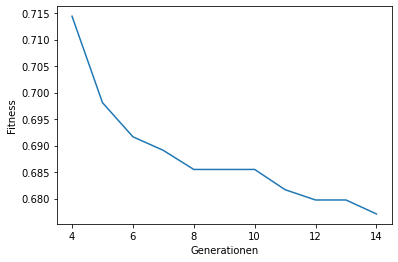

In [21]:
import matplotlib.pyplot as plt
plt.xlabel("Generationen")
plt.ylabel("Fitness")
#plot is cut to actually see something. before finding CF values are really high
plt.plot(cf_gen.plot_x[4:],cf_gen.plot_y[4:])